In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import fastparquet
import gc
import cPickle as pickle

In [3]:
stores_idx,items_idx,days_idx,states,cities,families,types = pickle.load(open("array_index.pkl"))

In [4]:
dim=(54, 4100, 1704)

In [5]:
def get_series(name):
    a=np.load("../input/s/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==dim
    return b
def get_series2(name):
    a=np.load("../input/s/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==(4100, 54, 1704)
    return b
def save_series(arr,name):
    assert arr.shape==dim
    print arr.dtype, arr.nbytes/1024.0**2
    np.savez_compressed("../input/s/"+name, arr)
def save_series2(arr,name):
    print arr.dtype, arr.nbytes/1024.0**2
    np.savez_compressed("../input/s/"+name, arr)    
def s_lag(arr,lag=1):
    l,m,n=arr.shape
    assert lag>0 and lag<n
    a=arr[:,:,:-lag]
    b=np.empty(shape=[l,m,lag],dtype=arr.dtype)
    b.fill(np.nan)
    ba=np.concatenate([b,a],axis=2)
    assert ba.shape==arr.shape
    assert ba.dtype==arr.dtype
    return ba

def forward(arr,step=1):
    l,m,n=arr.shape
    assert step>0 and step<n
    a=arr[:,:,step:]
    b=np.empty(shape=[l,m,step],dtype=arr.dtype)
    b.fill(np.nan)
    ba=np.concatenate([a,b],axis=2)
    assert ba.shape==arr.shape
    assert ba.dtype==arr.dtype
    return ba

In [6]:
def nan_equal(a,b):
    ret=( (np.abs(a - b)<1e1) | (numpy.isnan(a) & numpy.isnan(b)))
    #print np.where(~ret)
    #print a[~ret]
    #print b[~ret]
    return ret.all()
def test_mv():
    for i in range(30):
        print i,
        a=y0[i]
        df=pd.DataFrame(a.T,dtype=np.float64)
        b=pd.rolling_mean(df,window=3,min_periods=3/2+1).values
        c=y_mv3[i].T
        #print df.shape,b.shape,c.shape
        #print np.nansum(np.abs(b-c))
        assert nan_equal(b,c)        

In [7]:
def get_y(offset=0):
    assert offset>=0
    y0=get_series("y_0")
    if offset>0:
        y0=forward(y0,step=offset)
    return y0

In [8]:
cat_lag_features={
 "city_0",
  "class_0",
  "cluster_0",
  "family_0",
  "state_0",
  "type_0",

 'city_mv36',
 'class_mv36',
 'cluster_mv36',
 'family_mv36',
 'state_mv36',
 'type_mv36',    
 
 'item_mean_0',
 'store_mean_0',
 }
cat_features={
 'holiday_0',
 'onpromotion_0',
 'wage_0',
 }
oil_features={'oil_0', 'oil_d1', 'oil_d10', 'oil_d15', 'oil_d3', 'oil_d5'}
sales_ma_features={'sales_ma_112',
 'sales_ma_14',
 'sales_ma_224',
 'sales_ma_28',
 'sales_ma_3',
 'sales_ma_56',
 'sales_ma_7'}
sales_season_ma_features={'sales_week_season_ma_p13',
 'sales_week_season_ma_p2',
 'sales_week_season_ma_p3',
 'sales_week_season_ma_p4',
 'sales_week_season_ma_p7'}

In [9]:
#move x, fix y
def _get_feature(name,lag=0,offset=0):
    if name in cat_lag_features :
        assert lag == 0
        if name in ['item_mean_0','class_mv36','family_mv36','class_0','family_0']:
            s=get_series2(name)
        else:
            s=get_series(name)
        return s_lag(s,offset)
    if name in cat_features or name in oil_features:
        assert offset==0 and lag==0
        s= get_series(name)
        if name =='holiday_0': s[np.isnan(s)]=0
        return s
    if name =="y_0" or name in sales_ma_features or name in sales_season_ma_features:
        #assert  lag == 0
        s=get_series(name)
        if offset==0 and lag==0: return s
        return s_lag(s,lag=offset+lag)
def get_feature(name,lag=0,offset=0):
    s=_get_feature(name=name,lag=lag,offset=offset)
    if s.shape == ( 4100,54, 1704):
        s=np.rollaxis(s,1,0)
    assert s.shape==(54, 4100, 1704), s.shape
    return s

In [10]:
def get_all_features(offset=1):
    assert offset>0
    all_features=[]
    for name in cat_lag_features:
        all_features.append({"name":name,"lag":0,"offset":offset})
    for name in cat_features:
        all_features.append({"name":name,"lag":0,"offset":0})   
#     for name in oil_features:
#         all_features.append({"name":name,"lag":0,"offset":0})  
    for i in range(0,7):
        all_features.append({"name":"y_0","lag":i ,"offset":offset})  
    for name in sales_ma_features:
        all_features.append({"name":name,"lag":0,"offset":offset})  
    for name in sales_season_ma_features:
        all_features.append({"name":name,"lag":(700-offset)%7,"offset":offset})
#     for i in range(1,8):
#         all_features.append({"name":"oil_0","lag":i,"offset":offset})              
    return all_features    

In [11]:
def calc_feature(feat):
    return get_feature(**feat)

In [12]:
def nancorr2(a,b):
    idx=(~np.isnan(a)) & (~np.isnan(b))
    a=a[idx].flatten().astype(np.float64);b=b[idx].flatten().astype(np.float64)
    return np.corrcoef(a,b)[0,1],idx.sum()
def relation(a,b):
    idx=(~np.isnan(a)) & (~np.isnan(b))
    a=a[idx].flatten().astype(np.float64);b=b[idx].flatten().astype(np.float64)
    a=a-a.mean()
    b=b-b.mean()
    vara=(a*a).mean()
    varb=(b*b).mean()
    covab=(a*b).mean()
    return covab/np.sqrt(vara*varb),covab/varb,idx.sum()
def nancorr(y,x):
    a,b,c=relation(y,x)
    return a,b,c
def residual(y,x):
    a,b,c=relation(y,x)
    newx=x.copy()
    newx[np.isnan(newx)]=0
    return y-b*newx

In [65]:
promot=get_feature('onpromotion_0')

In [121]:
promot[0,3,1000:].sum()

32.0

In [137]:
i=8
(np.where(promot[0,i,1000:]>0)[0], \
np.where(promot3[0,i,1000:]>0)[0])

(array([  0,   1,   4,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
         55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  84,  86,  88,  91,  95,  97,  99, 101, 107, 109,
        115, 117, 118, 120, 121, 123, 125, 132, 133, 134, 135, 136, 139,
        140, 141, 143, 145, 146, 150, 153, 155, 157, 160, 163, 166, 167,
        175, 178, 179, 180, 188, 190, 210, 212, 214, 216, 221, 229, 230,
        231, 234, 235, 237, 243, 244, 247, 248, 251, 258, 263, 264, 265,
        266, 270, 273, 274, 283, 285, 286, 287, 292, 293, 298, 300, 304,
        306, 311, 314, 317, 319, 320, 323, 324, 326, 328, 329, 332, 333,
        336, 337, 342, 346, 348, 349, 351, 354, 355

In [101]:
u=np.sum(promot.reshape([-1,1704]),0,dtype=np.float)

In [102]:
u[1000:1688].mean(),u[1688:].mean(),(u/c)[1000:1688].mean(),(u/54/4100)[1688:].mean()

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


(14753.037790697674, 12412.3125, 0.072764726739256394, 0.056062838753387537)

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


(0, 0.14)

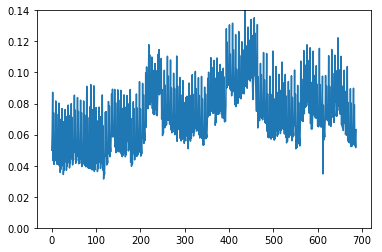

In [92]:
plt.plot((u/c)[1000:])
plt.ylim([0,0.14])

In [105]:
promot3=get_series('onpromotion1000_0')

In [110]:
u=np.nansum(promot3.reshape([-1,1704]),0,dtype=np.float)

In [111]:
u[1000:1688].mean(),u[1688:].mean(),(u/c)[1000:1688].mean(),(u/54/4100)[1688:].mean()

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


(14649.873546511628, 12412.3125, 0.072256179716783414, 0.056062838753387537)

In [112]:
plt.plot((u/c)[1000:])
plt.ylim([0,0.14]) 

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


(0, 0.14)

In [78]:
promot2=get_series('onpromotionraw_0')

In [93]:
u=np.nansum(promot2.reshape([-1,1704]),0,dtype=np.float)

In [100]:
u[1000:1688].mean(),u[1688:].mean(),(u/c)[1000:1688].mean(),(u/54/4100)[1688:].mean()

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


(9675.1351744186049, 12412.3125, 0.047298147356769175, 0.056062838753387537)

In [95]:
plt.plot((u/c)[1000:])
plt.ylim([0,0.14])plt.ylim([0,0.14])

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


(0, 0.14)

In [13]:
y=get_y(0)

In [32]:
def get_mask(y):
    mask=np.ones_like(y)
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            s=y[i,j]
            t=np.where(~np.isnan(s))[0]
            if len(t)>0:
                k=t[0]
                mask[i,j,:k]=0
    mask[:,:,1688:]=0
    return mask

In [33]:
b=get_mask(y)

In [57]:
b.shape

(54, 4100, 1704)

In [35]:
b.reshape([-1,1704]).mean(0).max()

1.0

In [49]:
c=b.reshape([-1,1704]).sum(0,dtype=np.float)

In [52]:
plt.plot(np.diff(c));
plt.ylim(0,1000)

(0, 1000)

In [53]:
d=(~np.isnan(y)).reshape([-1,1704]).sum(0,dtype=np.float)

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


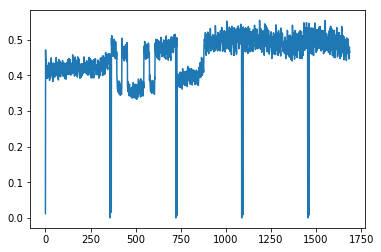

In [55]:
plt.plot(d/c);

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':
/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


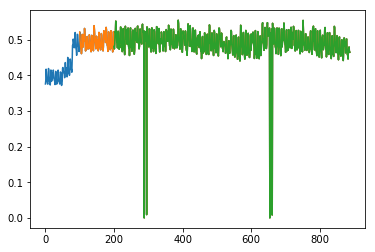

In [63]:
plt.plot( (d/c)[800:]);
plt.plot(np.arange(len(d)-900)+100, (d/c)[900:]);
plt.plot(np.arange(len(d)-1000)+200, (d/c)[1000:]);


In [48]:
b.max()

1.0

In [64]:
plt.plot(b.reshape([-1,1704]).mean(0));

In [21]:
a=y.copy()
a[np.isnan(a)]=0
print np.nanstd(y,dtype=np.float),np.nanstd(a,dtype=np.float)

0.928755607924 1.00658614559


In [23]:
a=y[:,:,900].copy()
a[np.isnan(a)]=0
print np.nanstd(y[:,:,900],dtype=np.float),np.nanstd(a,dtype=np.float)

0.999104593399 1.15402549446


In [15]:
a=y.reshape([-1,1704])

In [16]:
b=np.isnan(a).mean(0)

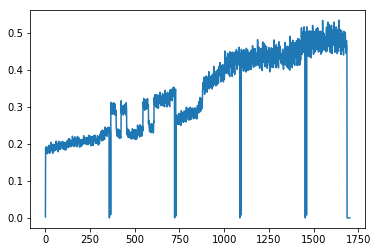

In [19]:
plt.plot(1-b);

In [30]:
correlations=[]

In [32]:
for feat in get_all_features(1)[::-1]:
    if feat in [u[0] for u in correlations]: continue
    print feat,
    x=    calc_feature(feat)
    r,b,c=nancorr(y,x)
    print r,b,c
    correlations.append([feat,r,b,c])

{'lag': 6, 'name': 'sales_week_season_ma_p3', 'offset': 1} 0.682466772785 0.616181272032 125250931
{'lag': 6, 'name': 'sales_week_season_ma_p2', 'offset': 1} 0.742247162981 0.745802732316 103433031
{'lag': 6, 'name': 'sales_week_season_ma_p13', 'offset': 1} 0.555135232373 0.454934241925 125250931
{'lag': 6, 'name': 'sales_week_season_ma_p4', 'offset': 1} 0.658044761914 0.580467281236 125250931
{'lag': 6, 'name': 'sales_week_season_ma_p7', 'offset': 1} 0.620078523511 0.52596914071 125250931
{'lag': 0, 'name': 'sales_ma_56', 'offset': 1} 0.802572110883 0.980526405708 107154702
{'lag': 0, 'name': 'sales_ma_3', 'offset': 1} 0.76191509162 0.845532692563 109443265
{'lag': 0, 'name': 'sales_ma_7', 'offset': 1} 0.79921929626 0.932858889381 111391999
{'lag': 0, 'name': 'sales_ma_112', 'offset': 1} 0.800109251996 0.984843229908 103523999
{'lag': 0, 'name': 'sales_ma_28', 'offset': 1} 0.804778841469 0.97279474323 109317283
{'lag': 0, 'name': 'sales_ma_14', 'offset': 1} 0.804577346616 0.9593609971

In [33]:
result=pd.DataFrame(correlations,columns=['feature','corr','beta','count']).sort_values("corr",ascending=False)
result.to_csv("corr_day0.csv")
result

feature      corr      beta  \
9   {u'lag': 0, u'name': u'sales_ma_28', u'offset'...  0.804779  0.972795   
10  {u'lag': 0, u'name': u'sales_ma_14', u'offset'...  0.804577  0.959361   
5   {u'lag': 0, u'name': u'sales_ma_56', u'offset'...  0.802572  0.980526   
8   {u'lag': 0, u'name': u'sales_ma_112', u'offset...  0.800109  0.984843   
7   {u'lag': 0, u'name': u'sales_ma_7', u'offset': 1}  0.799219  0.932859   
11  {u'lag': 0, u'name': u'sales_ma_224', u'offset...  0.794676  0.985104   
6   {u'lag': 0, u'name': u'sales_ma_3', u'offset': 1}  0.761915  0.845533   
1   {u'lag': 6, u'name': u'sales_week_season_ma_p2...  0.742247  0.745803   
12         {u'lag': 6, u'name': u'y_0', u'offset': 1}  0.725627  0.725668   
18         {u'lag': 0, u'name': u'y_0', u'offset': 1}  0.717388  0.717958   
13         {u'lag': 5, u'name': u'y_0', u'offset': 1}  0.696339  0.696008   
17         {u'lag': 1, u'name': u'y_0', u'offset': 1}  0.684249  0.685159   
0   {u'lag': 6, u'name': u'sales_week_season_ma_p3...  0.682467  0.616181   
14         {u'lag': 4, u'name': u'y_0', u'offset': 1}  0.675304  0.675000   
16         {u'lag': 2, u'name': u'y_0', u'offset': 1}  0.672359  0.672713   
15         {u'lag': 3, u'name': u'y_0', u'offset': 1}  0.669664  0.669791   
3   {u'lag': 6, u'name': u'sales_week_season_ma_p4...  0.658045  0.580467   
4   {u'lag': 6, u'name': u'sales_week_season_ma_p7...  0.620079  0.525969   
29  {u'lag': 0, u'name': u'item_mean_0', u'offset'...  0.615487  0.934071   
2   {u'lag': 6, u'name': u'sales_week_season_ma_p1...  0.555135  0.454934   
28     {u'lag': 0, u'name': u'class_0', u'offset': 1}  0.421737  0.920122   
24  {u'lag': 0, u'name': u'class_mv36', u'offset': 1}  0.418670  0.972490   
34    {u'lag': 0, u'name': u'family_0', u'offset': 1}  0.320250  0.851894   
22  {u'lag': 0, u'name': u'family_mv36', u'offset'...  0.318833  0.904963   
35  {u'lag': 0, u'name': u'store_mean_0', u'offset...  0.278077  0.859573   
32  {u'lag': 0, u'name': u'cluster_mv36', u'offset...  0.252509  0.980669   
31   {u'lag': 0, u'name': u'cluster_0', u'offset': 1}  0.249680  0.856547   
26   {u'lag': 0, u'name': u'type_mv36', u'offset': 1}  0.218239  0.976317   
27      {u'lag': 0, u'name': u'type_0', u'offset': 1}  0.215885  0.835277   
30   {u'lag': 0, u'name': u'city_mv36', u'offset': 1}  0.188087  1.037323   
33      {u'lag': 0, u'name': u'city_0', u'offset': 1}  0.186332  0.837610   
25  {u'lag': 0, u'name': u'state_mv36', u'offset': 1}  0.185169  1.030357   
23     {u'lag': 0, u'name': u'state_0', u'offset': 1}  0.184069  0.837265   
20  {u'lag': 0, u'name': u'onpromotion_0', u'offse...  0.032026  0.063036   
21   {u'lag': 0, u'name': u'holiday_0', u'offset': 0}  0.017950  0.057435   
19      {u'lag': 0, u'name': u'wage_0', u'offset': 0} -0.027357 -0.086481   

        count  
9   109317283  
10  109427495  
5   107154702  
8   103523999  
7   111391999  
11   96010172  
6   109443265  
1   103433031  
12  103433031  
18  105951916  
13  103019163  
17  104585161  
0   125250931  
14  103081619  
16  103818664  
15  103353239  
3   125250931  
4   125250931  
29  124793226  
2   125250931  
28  124993899  
24  123355088  
34  125052117  
22  124436659  
35  124758275  
32  124669776  
31  124802756  
26  124743249  
27  124925613  
30  124602199  
33  124777512  
25  124642053  
23  124790894  
20  125497040  
21  125497040  
19  125497040

In [35]:
correlations=[]
for feat in get_all_features(2)[::-1]:
    if feat in [u[0] for u in correlations]: continue
    print feat,
    x=    calc_feature(feat)
    r,b,c=nancorr(y,x)
    print r,b,c
    correlations.append([feat,r,b,c])

 {'lag': 5, 'name': 'sales_week_season_ma_p3', 'offset': 2} 0.682466772785 0.616181272032 125250931
{'lag': 5, 'name': 'sales_week_season_ma_p2', 'offset': 2} 0.742247162981 0.745802732316 103433031
{'lag': 5, 'name': 'sales_week_season_ma_p13', 'offset': 2} 0.555135232373 0.454934241925 125250931
{'lag': 5, 'name': 'sales_week_season_ma_p4', 'offset': 2} 0.658044761914 0.580467281236 125250931
{'lag': 5, 'name': 'sales_week_season_ma_p7', 'offset': 2} 0.620078523511 0.52596914071 125250931
{'lag': 0, 'name': 'sales_ma_56', 'offset': 2} 0.801458060312 0.979199991964 106923519
{'lag': 0, 'name': 'sales_ma_3', 'offset': 2} 0.744104044685 0.825439729001 108503644
{'lag': 0, 'name': 'sales_ma_7', 'offset': 2} 0.795125329284 0.928073142974 110839373
{'lag': 0, 'name': 'sales_ma_112', 'offset': 2} 0.7994099962 0.984008936956 103343013
{'lag': 0, 'name': 'sales_ma_28', 'offset': 2} 0.803032836336 0.970701401023 108997801
{'lag': 0, 'name': 'sales_ma_14', 'offset': 2} 0.801776038221 0.95607767

In [36]:
result=pd.DataFrame(correlations,columns=['feature','corr','beta','count']).sort_values("corr",ascending=False)
result.to_csv("corr_day1.csv")
result

feature      corr      beta  \
9   {u'lag': 0, u'name': u'sales_ma_28', u'offset'...  0.803033  0.970701   
10  {u'lag': 0, u'name': u'sales_ma_14', u'offset'...  0.801776  0.956078   
5   {u'lag': 0, u'name': u'sales_ma_56', u'offset'...  0.801458  0.979200   
8   {u'lag': 0, u'name': u'sales_ma_112', u'offset...  0.799410  0.984009   
7   {u'lag': 0, u'name': u'sales_ma_7', u'offset': 2}  0.795125  0.928073   
11  {u'lag': 0, u'name': u'sales_ma_224', u'offset...  0.794260  0.984597   
6   {u'lag': 0, u'name': u'sales_ma_3', u'offset': 2}  0.744104  0.825440   
1   {u'lag': 5, u'name': u'sales_week_season_ma_p2...  0.742247  0.745803   
13         {u'lag': 5, u'name': u'y_0', u'offset': 2}  0.725627  0.725668   
14         {u'lag': 4, u'name': u'y_0', u'offset': 2}  0.696339  0.696008   
12         {u'lag': 6, u'name': u'y_0', u'offset': 2}  0.692572  0.692854   
18         {u'lag': 0, u'name': u'y_0', u'offset': 2}  0.684249  0.685159   
0   {u'lag': 5, u'name': u'sales_week_season_ma_p3...  0.682467  0.616181   
15         {u'lag': 3, u'name': u'y_0', u'offset': 2}  0.675304  0.675000   
17         {u'lag': 1, u'name': u'y_0', u'offset': 2}  0.672359  0.672713   
16         {u'lag': 2, u'name': u'y_0', u'offset': 2}  0.669664  0.669791   
3   {u'lag': 5, u'name': u'sales_week_season_ma_p4...  0.658045  0.580467   
4   {u'lag': 5, u'name': u'sales_week_season_ma_p7...  0.620079  0.525969   
29  {u'lag': 0, u'name': u'item_mean_0', u'offset'...  0.588748  0.891986   
2   {u'lag': 5, u'name': u'sales_week_season_ma_p1...  0.555135  0.454934   
24  {u'lag': 0, u'name': u'class_mv36', u'offset': 2}  0.417243  0.969340   
28     {u'lag': 0, u'name': u'class_0', u'offset': 2}  0.394121  0.859292   
22  {u'lag': 0, u'name': u'family_mv36', u'offset'...  0.317776  0.902161   
34    {u'lag': 0, u'name': u'family_0', u'offset': 2}  0.294315  0.781750   
32  {u'lag': 0, u'name': u'cluster_mv36', u'offset...  0.251080  0.975199   
35  {u'lag': 0, u'name': u'store_mean_0', u'offset...  0.242783  0.752147   
26   {u'lag': 0, u'name': u'type_mv36', u'offset': 2}  0.216735  0.969732   
31   {u'lag': 0, u'name': u'cluster_0', u'offset': 2}  0.215911  0.742930   
30   {u'lag': 0, u'name': u'city_mv36', u'offset': 2}  0.186068  1.026224   
25  {u'lag': 0, u'name': u'state_mv36', u'offset': 2}  0.183174  1.019295   
27      {u'lag': 0, u'name': u'type_0', u'offset': 2}  0.179985  0.699498   
33      {u'lag': 0, u'name': u'city_0', u'offset': 2}  0.143215  0.644628   
23     {u'lag': 0, u'name': u'state_0', u'offset': 2}  0.140855  0.641526   
20  {u'lag': 0, u'name': u'onpromotion_0', u'offse...  0.032026  0.063036   
21   {u'lag': 0, u'name': u'holiday_0', u'offset': 0}  0.017950  0.057435   
19      {u'lag': 0, u'name': u'wage_0', u'offset': 0} -0.027357 -0.086481   

        count  
9   108997801  
10  109006468  
5   106923519  
8   103343013  
7   110839373  
11   95871089  
6   108503644  
1   103433031  
13  103433031  
14  103019163  
12  102419519  
18  104585161  
0   125250931  
15  103081619  
17  103818664  
16  103353239  
3   125250931  
4   125250931  
29  124642678  
2   125250931  
24  123234707  
28  124878643  
22  124375506  
34  124994144  
32  124626505  
35  124704955  
26  124702404  
31  124770607  
30  124556541  
25  124598292  
27  124897005  
33  124741878  
23  124757137  
20  125497040  
21  125497040  
19  125497040

In [37]:
correlations=[]

In [38]:
for feat in get_all_features(15):
    if feat in [u[0] for u in correlations]: continue
    print feat,
    x=    calc_feature(feat)
    r,b,c=nancorr(y,x)
    print r,b,c
    correlations.append([feat,r,b,c])
    

{'lag': 0, 'name': 'store_mean_0', 'offset': 15} 0.265579113209 0.820427603554 123921442
{'lag': 0, 'name': 'family_0', 'offset': 15} 0.31050243596 0.822868989392 124253980
{'lag': 0, 'name': 'city_0', 'offset': 15} 0.171460443692 0.770030116757 124145628
{'lag': 0, 'name': 'cluster_mv36', 'offset': 15} 0.249672317153 0.969935054439 124057220
{'lag': 0, 'name': 'cluster_0', 'offset': 15} 0.238368776799 0.817864332585 124223813
{'lag': 0, 'name': 'city_mv36', 'offset': 15} 0.184000419285 1.01562097001 123945469
{'lag': 0, 'name': 'item_mean_0', 'offset': 15} 0.588959494959 0.892380079965 122548387
{'lag': 0, 'name': 'class_0', 'offset': 15} 0.407050897627 0.889227111885 123402547
{'lag': 0, 'name': 'type_0', 'offset': 15} 0.205581098615 0.795609242166 124387367
{'lag': 0, 'name': 'type_mv36', 'offset': 15} 0.215511165412 0.964965484376 124170556
{'lag': 0, 'name': 'state_mv36', 'offset': 15} 0.181332554573 1.00983621192 124012748
{'lag': 0, 'name': 'class_mv36', 'offset': 15} 0.41327800

In [39]:
result=pd.DataFrame(correlations,columns=['feature','corr','beta','count']).sort_values("corr",ascending=False)
result.to_csv("corr_day15.csv")
result

feature      corr      beta  \
30  {u'lag': 0, u'name': u'sales_ma_56', u'offset'...  0.794521  0.969775   
27  {u'lag': 0, u'name': u'sales_ma_112', u'offset...  0.794474  0.977656   
26  {u'lag': 0, u'name': u'sales_ma_28', u'offset'...  0.790889  0.956284   
24  {u'lag': 0, u'name': u'sales_ma_224', u'offset...  0.790651  0.979855   
25  {u'lag': 0, u'name': u'sales_ma_14', u'offset'...  0.783487  0.934356   
28  {u'lag': 0, u'name': u'sales_ma_7', u'offset':...  0.772873  0.902207   
29  {u'lag': 0, u'name': u'sales_ma_3', u'offset':...  0.732820  0.813041   
34  {u'lag': 6, u'name': u'sales_week_season_ma_p2...  0.730491  0.733710   
23        {u'lag': 6, u'name': u'y_0', u'offset': 15}  0.705286  0.705124   
17        {u'lag': 0, u'name': u'y_0', u'offset': 15}  0.684124  0.684404   
22        {u'lag': 5, u'name': u'y_0', u'offset': 15}  0.676653  0.676241   
18        {u'lag': 1, u'name': u'y_0', u'offset': 15}  0.659983  0.660160   
21        {u'lag': 4, u'name': u'y_0', u'offset': 15}  0.655300  0.655112   
35  {u'lag': 6, u'name': u'sales_week_season_ma_p3...  0.653670  0.581585   
19        {u'lag': 2, u'name': u'y_0', u'offset': 15}  0.650476  0.650445   
20        {u'lag': 3, u'name': u'y_0', u'offset': 15}  0.648876  0.648889   
32  {u'lag': 6, u'name': u'sales_week_season_ma_p4...  0.638268  0.556440   
31  {u'lag': 6, u'name': u'sales_week_season_ma_p7...  0.597594  0.502840   
6   {u'lag': 0, u'name': u'item_mean_0', u'offset'...  0.588959  0.892380   
33  {u'lag': 6, u'name': u'sales_week_season_ma_p1...  0.544126  0.444110   
11  {u'lag': 0, u'name': u'class_mv36', u'offset':...  0.413278  0.963224   
7     {u'lag': 0, u'name': u'class_0', u'offset': 15}  0.407051  0.889227   
13  {u'lag': 0, u'name': u'family_mv36', u'offset'...  0.316444  0.902156   
1    {u'lag': 0, u'name': u'family_0', u'offset': 15}  0.310502  0.822869   
0   {u'lag': 0, u'name': u'store_mean_0', u'offset...  0.265579  0.820428   
3   {u'lag': 0, u'name': u'cluster_mv36', u'offset...  0.249672  0.969935   
4   {u'lag': 0, u'name': u'cluster_0', u'offset': 15}  0.238369  0.817864   
9   {u'lag': 0, u'name': u'type_mv36', u'offset': 15}  0.215511  0.964965   
8      {u'lag': 0, u'name': u'type_0', u'offset': 15}  0.205581  0.795609   
5   {u'lag': 0, u'name': u'city_mv36', u'offset': 15}  0.184000  1.015621   
10  {u'lag': 0, u'name': u'state_mv36', u'offset':...  0.181333  1.009836   
2      {u'lag': 0, u'name': u'city_0', u'offset': 15}  0.171460  0.770030   
12    {u'lag': 0, u'name': u'state_0', u'offset': 15}  0.169828  0.771795   
15  {u'lag': 0, u'name': u'onpromotion_0', u'offse...  0.032026  0.063036   
14   {u'lag': 0, u'name': u'holiday_0', u'offset': 0}  0.017950  0.057435   
16      {u'lag': 0, u'name': u'wage_0', u'offset': 0} -0.027357 -0.086481   

        count  
30  104849456  
27  101364253  
26  105952909  
24   94222603  
25  105566026  
28  107033147  
29  104627960  
34   99768247  
23   99768247  
17  100687185  
22   99565887  
18  100195388  
21   99523101  
35  124686923  
19   99860385  
20   99640530  
32  124686923  
31  124686923  
6   122548387  
33  124686923  
11  121854759  
7   123402547  
13  123655750  
1   124253980  
0   123921442  
3   124057220  
4   124223813  
9   124170556  
8   124387367  
5   123945469  
10  124012748  
2   124145628  
12  124187723  
15  125497040  
14  125497040  
16  125497040

In [40]:
import gc
gc.collect()

762